## Citation  
#### Baevski, A., Schneider, S., & Auli, M. (2020). vq-wav2vec: Self-Supervised Learning of Discrete Speech Representations. arXiv:1910.05453. https://doi.org/10.48550/arXiv.1910.05453

#### This notebook is a personal explanation and walkthrough of the paper vq-wav2vec: Self-Supervised Learning of Discrete Speech Representations. All credit for the original research goes to the authors listed above.


**Image Attribution**

#### Unless otherwise noted, all figures in this notebook are either original or sourced from Baevski et al., 2020 — vq-wav2vec: Self-Supervised Learning of Discrete Speech Representations.

# Vq-Wav2Vec Architecture

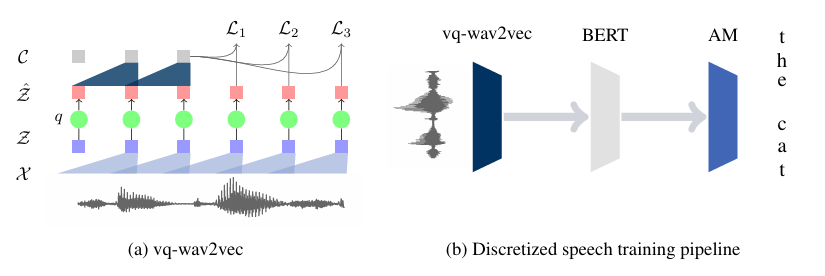

In [1]:
%matplotlib inline
from IPython.display import Image
Image('Images/vq-wav2vec-architecture.png')

#### The Vq-Wav2Vec is built on top of Wav2Vec. Vq-wav2vec introduces the concept of quantization (q).
#### The audio input (X) is passed to the encoding layer where the audio is transformed to dense representation. These vectors is quantized (q) to Z_cap where it is aggregated to context representations (C). 
#### These context representations (C) is then passed to BERT where it encodes into meaningful context and then it is passed to the Acoustic Model to predict the sentence/word of the input audio.

# Architectural Flow of Vq-Wav2Vec
#### Vq-Wav2Vec follows similar process as Wav2Vec: It has 2 convolutional layer. Only addition is the quantization module.
#### f: X->Z (Convolutional layer where the audio is transformed to dense representations). This is the feature extraction layer.
#### q: Z->Z_cap (Quantization module/function where the Dense representation is transformed to qunatization representation).
#### g: Z_cap->C (Convolutional layer where the quantization representation is transformed to contextual representation). This is the feature aggregation layer.

#### Quantization module is like creating a dictionary of speech sounds so that the computer can understand.
#### The goal is to replace continuous dense vector z with discrete vector z_cap from a fixed codebook.

#### A codebook is a matrix of size Vxd where there are V possible codeword vectors, each with dimension d. It is like a dictionary containing V fixed vectors (codewords). It is denoted as e. e = [e_1, e_2, ... , e_v] where e_i is a d-dimensional vector. 
#### During training, the model will learn a lot of learned vectors (V). When the new audio comes, the encoder produces a feature vector for a short segment. The quantization module will find the codeword in the codebook that is similar or closer to each other and replaces the original vector with the codeword.This process is called is called vector quantization.

# Quantization methods

#### The neural network has to choose one codeword (which is similar to the continuous features (z)) from the codebook. argmax can be used to pick the best possible codeword but argmax is non differentiable. So, gradients can't flow through it during backpropagation.

#### No gradient means No learning. Hence, argmax cannot be used.
#### Quantization methods are the methods which are used to convert continuous features into discrete features. They find the best codeword from the codebook. There are many quantization methods. Vq-Wav2Vec is tested with 2 types of quantization methods:
#### 1) Gumbel-Softmax
#### 2) K-Means

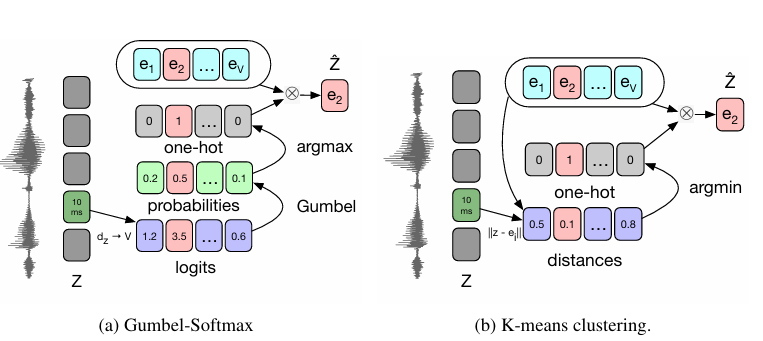

In [1]:
%matplotlib inline
from IPython.display import Image
Image('Images/Gumbel-Softmax and K-means clustering.png')

# 1) Gumbel-Softmax
#### Gumbel-Softmax is like a Smart Guesser.
#### The dense representation (z) is passed through three layers: Linear -> ReLU -> Linear. This produces logits (l).
#### Logits (l) are vectors representing scores for each of the V options in the codebook. In the example above, l = [1.2, 3.5, ..., 0.6]
#### Gumbel noise is added to each logit. This is because it makes the sampling equivalent to taking an argmax. Only difference is that there is a noise.
#### Then temperature-controlled softmax is used.

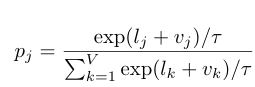

In [8]:
%matplotlib inline
from IPython.display import Image
Image('Images/gumbel-softmax.png')

#### τ is the temperature which controls the sharpness.
#### High temperature means exploring more. It is a soft, distrbuted probabilities.
#### Low temperatures means more decisive. It is a sharp, concentrated probabilities.


#### Then a straight-through estimator is used. It consists of two passes.
#### a) Forward Pass: Uses discrete selection i=argmax_j p_j. That is choose z_cap = e_i.
#### b) Backward Pass: Use the continuous probabilities p_j for gradient computation.

# K-Means
#### The codebook (e) serves as the centroids.
#### Forward Pass: For each encoder output (z), find the nearest codeword by Euclidean Distance: i = argmin_j ||z - e_j||^2. 
#### Assign z_cap = e_i (The best codeword)

#### Backward Pass: The gradients of the encoder network is obtained by back-propagating d(L_wav2vec)/d(z_cap)

# Final Loss

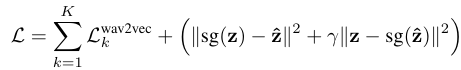

In [9]:
%matplotlib inline
from IPython.display import Image
Image('Images/K-Means Loss.png')

#### There are three terms in the Loss calculation for Quantization Module using K-Means: 
### a) Self-supervised future prediction loss
### b) Codebook Update Loss
### c) Commitment Loss

# a) Self-supervised future prediction loss

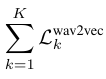

In [11]:
%matplotlib inline
from IPython.display import Image
Image('Images/Self-supervised future prediction loss.png')

#### This makes the model to learn good speech representations by predicting future frames from context.
#### Gradients flow through the encoder and context network but they do not change the codebooks because Straight-Through gradient Estimation (STE). With Straight-Through estimator, the forward pass uses quantized z_cap but in the backward pass, it pretends the function is identity so that gradients flow as if quantization didn't block them. 
#### This enables learning even though quantization is non-differentiable.

# b) Codebook Update Loss

In [12]:
%matplotlib inline
from IPython.display import Image
Image('Images/Codebook Update Loss.png')

#### Codebook update loss is done to adapt the centroids to the data distribution. This is done by (||sg(z) - z_cap||)^2 where sg(z) acts as a constant during backpropagation. This is because only the codebook vectors (z_cap) is updated
#### In other words, the codebook vectors (z_cap) is moved closer to the encoder representation (z). 

# Commitment Loss

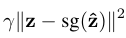

In [13]:
%matplotlib inline
from IPython.display import Image
Image('Images/Commitment Loss.png')

#### This makes sure the encoder outputs (z) are close to centroid (codeword). 
#### The stop-gradient on z_cap (sg(z_cap)) means only the encoder parameters are updated.
#### γ is a hyperparameter where it balances the strength of this loss relative to the other terms 
#### If γ is too small, the encoder outputs (z) may not stay close to the discrete codewords (z_cap), causing instability and large quantization errors.
#### If γ is too large, the encoder might focus only on matching codewords and it may sacrifice useful predictive features.


#### All the three terms are added because the end goal is to minimize the loss. So everything is added and then the model is trainined to minimize this total loss.

# Verctor quantization with Multiple variable groups
#### Using only 1 codebook to quantize the entire encoder output vector (z) may lead to mode collapse.
#### Mode collapse occurs when only a small subset of codewords is used repeatedly. This reduces the diversity of discrete representations.

#### To address this issue, multiple groups strategy is implemented.
#### The dense endocer feature vector (z) of dimension d is split into G groups to form a matrix z'_g. Each of this group is a subvector of length d/G.
#### For each group, a discrete codeword is selected independently using either Gumbel-Softmax or K-means quantization methods.
#### The codebooks can be any of the 2 types:

#### i) Shared Codebook across groups: The same set of codeword vectors (e) is used across all the groups. Each codeword vector is of size Vx(d/G)

#### ii) Seperate Codebook per group: Each group has its own independet codebook (e), increasing memory but it has finer distinctions. Each codeword vector is of size VxGx(d/G)

# BERT Pre-Training on Quantized Speech
#### After training vq-wav2vec, speech audio is converted into discrete tokens.
#### These tokens can be used as input to BERT for pre-training. BERT learns to predict the missing tokens based on the surrounding context (Masked Language Model or MLM for short).
#### Each token represents 10ms, predicting 1 token is easy. Hence, BERT masks spans of consecutive tokens to make learning task harder.
#### The trained BERT model can then generate better speech representation that improve automatic speech recognition (ASR) downstream tasks.

# Conclusion
#### vq-wav2vec first learns discrete speech representations by applying vector quantization to dense encoder outputs combined with a self-supervised context prediction task.

#### These discrete tokens are then used as input to BERT for pre-training with masked token prediction, enhancing the learned speech representations.

#### The output embeddings from the pretrained BERT model are fed into a downstream acoustic model, which performs speech recognition by predicting the corresponding text transcription.